# Setup and Data Preparation


In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For machine learning strategy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load your data
df = pd.read_csv('ICLN_data_with_sentiment.csv', index_col=0)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

# Calculate percentage change
df['Change_Percentage'] = df['Close'].pct_change() * 100
df.dropna(inplace=True)

# save the original columns
original_columns = df.drop(columns=['Date']).columns.to_list()

# Reset index for sequential data
# df = df.reset_index()

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,...,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent,close_XLU_etf,close_XLK_etf,close_XLI_etf,Sentiment_Score,Change_Percentage
2394,2017-08-29,9.02,9.08,9.00,9.07,8.224794,73500.0,9.07,9.06,9.07,...,10.879,84.419998,10192.599609,48.400002,111.400002,55.119999,58.060001,67.949997,-0.169282,0.000000
2395,2017-08-30,9.08,9.11,9.05,9.11,8.261068,73500.0,9.07,9.02,9.08,...,10.863,84.080002,10245.799805,48.090000,112.300003,54.959999,58.480000,68.230003,0.133812,0.441014
2396,2017-08-31,9.11,9.13,9.05,9.13,8.279206,443400.0,9.11,9.08,9.11,...,10.814,84.269997,10299.500000,46.959999,113.800003,54.970001,58.830002,68.459999,-0.144115,0.219539
2397,2017-09-01,9.13,9.18,9.12,9.16,8.306409,571800.0,9.13,9.11,9.13,...,10.853,83.989998,10325.500000,47.840000,115.000000,54.799999,58.779999,68.519997,0.154116,0.328587
2398,2017-09-04,9.13,9.18,9.12,9.16,8.306409,571800.0,9.13,9.11,9.13,...,10.853,83.989998,10325.500000,47.840000,115.000000,54.799999,58.779999,68.519997,-0.174625,0.000000


In [313]:
print('Train:')
print(f'Start date: {train_df.Date.min()}')
print(f'Start date: {train_df.Date.max()}')
print(f'Period length: {len(pd.date_range(start=train_df.Date.min(), end=train_df.Date.max()))} days\n')
print('Test:')
print(f'Start date: {test_df.Date.min()}')
print(f'Start date: {test_df.Date.max()}')
print(f'Period length: {len(pd.date_range(start=test_df.Date.min(), end=test_df.Date.max()))} days\n')


Train:
Start date: 2017-08-29
Start date: 2023-02-22
Period length: 2004 days

Test:
Start date: 2023-02-23
Start date: 2024-07-08
Period length: 502 days



# Implementing the Strategies


## Moving Average Crossover Strategy


In [314]:
# Calculate moving averages
df['MA_Short'] = df['Close'].rolling(window=10).mean()
df['MA_Long'] = df['Close'].rolling(window=50).mean()

# Use only the test data
test_df['MA_Short'] = df['MA_Short'].iloc[train_size:].values
test_df['MA_Long'] = df['MA_Long'].iloc[train_size:].values

# Define buffer
buffer = 0.1  # Buffer of 0.1 units (adjust as needed)

# Calculate difference
test_df['MA_Diff'] = test_df['MA_Short'] - test_df['MA_Long']

# Generate signals
test_df['Signal_MACrossover'] = 0
test_df.loc[test_df['MA_Diff'] > buffer, 'Signal_MACrossover'] = 1
test_df.loc[test_df['MA_Diff'] < -buffer, 'Signal_MACrossover'] = -1

# Simulate trades
test_df['Return_MACrossover'] = test_df['Signal_MACrossover'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Momentum-Based Trading Strategy

In [315]:
# Replace this with your actual model predictions
test_df['Predicted_Change'] = test_df['Close'].rolling(window=5).mean().pct_change() * 100
test_df['Predicted_Change'].fillna(0, inplace=True)

# Define thresholds
threshold_buy = 0.5  # 0.5% predicted increase
threshold_sell = -0.5  # -0.5% predicted decrease

# Generate signals
test_df['Signal_Momentum'] = 0  # Default to do nothing
test_df.loc[test_df['Predicted_Change'] > threshold_buy, 'Signal_Momentum'] = 1
test_df.loc[test_df['Predicted_Change'] < threshold_sell, 'Signal_Momentum'] = -1

# Simulate trades
test_df['Return_Momentum'] = test_df['Signal_Momentum'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Bollinger Bands Strategy

In [316]:
# Calculate Bollinger Bands
df['MA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['STD20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['STD20'] * 2)

# Use only the test data
test_df['MA20'] = df['MA20'].iloc[train_size:].values
test_df['Upper_Band'] = df['Upper_Band'].iloc[train_size:].values
test_df['Lower_Band'] = df['Lower_Band'].iloc[train_size:].values

# Define band margin
band_margin = 0.01  # 1% margin

# Generate signals
test_df['Signal_Bollinger'] = 0
test_df.loc[test_df['Close'] < test_df['Lower_Band'] * (1 - band_margin), 'Signal_Bollinger'] = 1
test_df.loc[test_df['Close'] > test_df['Upper_Band'] * (1 + band_margin), 'Signal_Bollinger'] = -1

# Simulate trades
test_df['Return_Bollinger'] = test_df['Signal_Bollinger'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Mean Reversion Strategy

In [317]:
# Calculate moving average and standard deviation
df['MA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()

# Use only the test data
test_df['MA20'] = df['MA20'].iloc[train_size:].values
test_df['STD20'] = df['STD20'].iloc[train_size:].values

# Define threshold
threshold = 1  # Number of standard deviations

# Calculate z-score (number of standard deviations from MA)
test_df['Z_Score'] = (test_df['Close'] - test_df['MA20']) / test_df['STD20']

# Generate signals
test_df['Signal_MeanReversion'] = 0
test_df.loc[test_df['Z_Score'] < -threshold, 'Signal_MeanReversion'] = 1  # Buy
test_df.loc[test_df['Z_Score'] > threshold, 'Signal_MeanReversion'] = -1  # Sell

# Simulate trades
test_df['Return_MeanReversion'] = test_df['Signal_MeanReversion'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## RSI Overbought/Oversold Strategy

In [318]:
# Calculate RSI
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_RSI(df['Close'])

# Use only the test data
test_df['RSI'] = df['RSI'].iloc[train_size:].values

# Define thresholds
oversold_threshold = 25
overbought_threshold = 75

# Generate signals
test_df['Signal_RSI'] = 0
test_df.loc[test_df['RSI'] < oversold_threshold, 'Signal_RSI'] = 1
test_df.loc[test_df['RSI'] > overbought_threshold, 'Signal_RSI'] = -1

# Simulate trades
test_df['Return_RSI'] = test_df['Signal_RSI'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Combined Strategy with Predictive Model and Technical Indicators

In [319]:
# Calculate RSI
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_RSI(df['Close'])

# Calculate MACD
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Prepare test data
test_df['RSI'] = df['RSI'].iloc[train_size:].values
test_df['MACD'] = df['MACD'].iloc[train_size:].values
test_df['Signal_Line'] = df['Signal_Line'].iloc[train_size:].values


In [320]:
# Generate signals
test_df['Signal_Combined'] = 0

# Buy condition
buy_conditions = (
    (test_df['Predicted_Change'] > threshold_buy) &  # Use thresholds similar to momentum strategy
    (test_df['RSI'] < 30) &
    (test_df['MACD'] > test_df['Signal_Line'])
)

# Sell condition
sell_conditions = (
    (test_df['Predicted_Change'] < threshold_sell) &
    (test_df['RSI'] > 70) &
    (test_df['MACD'] < test_df['Signal_Line'])
)

test_df.loc[buy_conditions, 'Signal_Combined'] = 1
test_df.loc[sell_conditions, 'Signal_Combined'] = -1

# Simulate trades
test_df['Return_Combined'] = test_df['Signal_Combined'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Breakout Strategy

In [321]:
# Calculate rolling high and low
df['Rolling_Max'] = df['High'].rolling(window=20).max()
df['Rolling_Min'] = df['Low'].rolling(window=20).min()

# Use only the test data
test_df['Rolling_Max'] = df['Rolling_Max'].iloc[train_size:].values
test_df['Rolling_Min'] = df['Rolling_Min'].iloc[train_size:].values

# Define breakout margin
breakout_margin = 0.01  # 1% margin

# Generate signals
test_df['Signal_Breakout'] = 0
test_df.loc[test_df['Close'] > test_df['Rolling_Max'].shift(1) * (1 + breakout_margin), 'Signal_Breakout'] = 1
test_df.loc[test_df['Close'] < test_df['Rolling_Min'].shift(1) * (1 - breakout_margin), 'Signal_Breakout'] = -1

# Simulate trades
test_df['Return_Breakout'] = test_df['Signal_Breakout'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## MACD Crossover Strategy

In [322]:
# Use only the test data
test_df['MACD'] = df['MACD'].iloc[train_size:].values
test_df['Signal_Line'] = df['Signal_Line'].iloc[train_size:].values

# Define MACD threshold
macd_threshold = 0.1  # Adjust based on data scale

# Calculate MACD difference
test_df['MACD_Diff'] = test_df['MACD'] - test_df['Signal_Line']

# Generate signals
test_df['Signal_MACD'] = 0
test_df.loc[(test_df['MACD_Diff'] > macd_threshold) & (test_df['MACD_Diff'].shift(1) <= macd_threshold), 'Signal_MACD'] = 1
test_df.loc[(test_df['MACD_Diff'] < -macd_threshold) & (test_df['MACD_Diff'].shift(1) >= -macd_threshold), 'Signal_MACD'] = -1

# Simulate trades
test_df['Return_MACD'] = test_df['Signal_MACD'] * (test_df['Close'] - test_df['Open']) / test_df['Open']

## Machine Learning / Deep Learning Strategy

### Random Forest Classifier

In [323]:
# Prepare labels
df['Future_Return'] = df['Close'].shift(-1) - df['Close']
df['Label'] = np.where(df['Future_Return'] > 0, 1, 0)
df.set_index('Date', inplace=True)

# Prepare features
features = df.drop(columns=['Change_Percentage', 'Close']).columns.tolist()

# Split data
X = df[features]
y = df['Label']

X_train_rf = X.iloc[:train_size]
y_train_rf = y.iloc[:train_size]
X_test_rf = X.iloc[train_size:]
y_test_rf = y.iloc[train_size:]

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_rf, y_train_rf)

# Set probability threshold
prob_threshold = 0.6  # 60% confidence

# Make predictions with probabilities
y_pred_prob = clf.predict_proba(X_test_rf)

# Initialize signals
test_df['Signal_RF'] = 0

# Generate signals based on probabilities
test_df.loc[y_pred_prob[:, 1] > prob_threshold, 'Signal_RF'] = 1  # Probability of class 1 (price goes up)
test_df.loc[y_pred_prob[:, 0] > prob_threshold, 'Signal_RF'] = -1  # Probability of class 0 (price goes down)

# Simulate trades
test_df['Return_RF'] = test_df['Signal_RF'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


### XGBoost

In [324]:
import xgboost as xgb

# Split data
X_train_xgb = X.iloc[:train_size]
y_train_xgb = y[:train_size]
X_test_xgb = X.iloc[train_size:]
y_test_xgb = y[train_size:]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions with probabilities
y_pred_prob = xgb_model.predict(dtest)

# Initialize signals
test_df['Signal_XGBoost'] = 0

# Generate signals based on probability threshold
prob_threshold = 0.6  # 60% confidence

test_df.loc[y_pred_prob > prob_threshold, 'Signal_XGBoost'] = 1
test_df.loc[y_pred_prob < (1 - prob_threshold), 'Signal_XGBoost'] = -1

# Simulate trades
test_df['Return_XGBoost'] = test_df['Signal_XGBoost'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


### Long Short-Term Memory (LSTM)

In [325]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Recalculate train_size based on the new df length
train_size = int(len(df) * 0.8)

# Prepare data
sequence_length = 10  # Number of past time steps to use

# Extract features and target
df = df[original_columns]  # Restore original columns
features_list = df.drop(columns=['Change_Percentage', 'Close'], inplace=False).columns.tolist()
lstm_features = df[features_list].values
lstm_target = df['Change_Percentage'].values  # Predicting the change in closing price

# Scale features
scaler = StandardScaler()
lstm_features_scaled = scaler.fit_transform(lstm_features)

# Create sequences
def create_sequences(features, target, seq_length):
    xs = []
    ys = []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_lstm, y_lstm = create_sequences(lstm_features_scaled, lstm_target, sequence_length)

# Split data
X_train_lstm = X_lstm[:train_size - sequence_length]
y_train_lstm = y_lstm[:train_size - sequence_length]
X_test_lstm = X_lstm[train_size - sequence_length:]
y_test_lstm = y_lstm[train_size - sequence_length:]

# Convert to tensors
X_train_lstm = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_lstm = torch.tensor(y_train_lstm, dtype=torch.float32)
X_test_lstm = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_lstm = torch.tensor(y_test_lstm, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Enhanced LSTM Model
class EnhancedLSTMStrategy(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(EnhancedLSTMStrategy, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            dropout=dropout_rate, bidirectional=True, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)  # For bidirectional LSTM
        self.fc = nn.Linear(hidden_size * 2, 1)  # Match dimensions with bidirectional LSTM output
        
    def forward(self, x):
        h_0 = torch.zeros(num_layers * 2, x.size(0), hidden_size)  # *2 for bidirectional
        c_0 = torch.zeros(num_layers * 2, x.size(0), hidden_size)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        # Apply Layer Normalization
        output = self.layer_norm(output[:, -1, :])  # Normalize the last time step
        
        # Fully connected layer
        out = self.fc(output)
        return out

# Model hyperparameters
input_size = X_train_lstm.shape[2]
hidden_size = 64
num_layers = 2
dropout_rate = 0.3

model_lstm = EnhancedLSTMStrategy(input_size, hidden_size, num_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)  # Learning rate scheduler

# Training the enhanced model
num_epochs = 100
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_lstm(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    scheduler.step()  # Adjust learning rate
    if (epoch+1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model_lstm.eval()
with torch.no_grad():
    y_pred_lstm = model_lstm(X_test_lstm)

# Convert predictions to numpy
y_pred_lstm_np = y_pred_lstm.numpy().squeeze()

# Generate signals
test_df['Signal_LSTM'] = 0

# Define price change percentage thresholds
threshold_buy = 1  
threshold_sell = -1  

# Generate signals
test_df.loc[y_pred_lstm_np > threshold_buy, 'Signal_LSTM'] = 1
test_df.loc[y_pred_lstm_np < threshold_sell, 'Signal_LSTM'] = -1

# Simulate trades
test_df['Return_LSTM'] = test_df['Signal_LSTM'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


LSTM Epoch [10/100], Loss: 4.9025
LSTM Epoch [20/100], Loss: 2.8111
LSTM Epoch [30/100], Loss: 0.5801
LSTM Epoch [40/100], Loss: 1.9533
LSTM Epoch [50/100], Loss: 1.6411
LSTM Epoch [60/100], Loss: 2.3974
LSTM Epoch [70/100], Loss: 0.2443
LSTM Epoch [80/100], Loss: 1.1714
LSTM Epoch [90/100], Loss: 1.1253
LSTM Epoch [100/100], Loss: 1.0578


### Transformer

In [326]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Recalculate train_size based on the new df length
train_size = int(len(df) * 0.8)

# Prepare data
sequence_length = 10  # Number of past time steps to use

# Extract features and target
df = df[original_columns]  # Restore original columns
features_list = df.drop(columns=['Change_Percentage', 'Close'], inplace=False).columns.tolist()
features = df[features_list].values
target = df['Change_Percentage'].values  # Predicting the percentage change in Close price

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences
def create_sequences(features, target, seq_length):
    xs = []
    ys = []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(features_scaled, target, sequence_length)

# Split data
X_train = X[:train_size - sequence_length]
y_train = y[:train_size - sequence_length]
X_test = X[train_size - sequence_length:]
y_test = y[train_size - sequence_length:]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Define Transformer Model for predicting change percentage
class TransformerStrategy(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, nhead, num_outputs=1):
        super(TransformerStrategy, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, num_outputs)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        out = self.fc(x[:, -1, :])  # Use the last output for regression
        return out

# Model parameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
nhead = 4

# Initialize Transformer model
model_transformer = TransformerStrategy(input_size, hidden_size, num_layers, nhead)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_transformer(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Transformer Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model_transformer.eval()
with torch.no_grad():
    y_pred = model_transformer(X_test)

# Convert predictions to numpy
y_pred_np = y_pred.numpy().squeeze()

# Define thresholds
threshold_buy = 1  # 1% predicted increase
threshold_sell = -1  # -1% predicted decrease

# Generate signals based on predicted change percentage
test_df['Signal_Transformer'] = 0
test_df.loc[y_pred_np > threshold_buy, 'Signal_Transformer'] = 1
test_df.loc[y_pred_np < threshold_sell, 'Signal_Transformer'] = -1

# Simulate trades
test_df['Return_Transformer'] = test_df['Signal_Transformer'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


Transformer Epoch [10/100], Loss: 1.3509
Transformer Epoch [20/100], Loss: 1.8729
Transformer Epoch [30/100], Loss: 1.5203
Transformer Epoch [40/100], Loss: 1.2345
Transformer Epoch [50/100], Loss: 1.2864
Transformer Epoch [60/100], Loss: 1.0394
Transformer Epoch [70/100], Loss: 1.6271
Transformer Epoch [80/100], Loss: 0.7295
Transformer Epoch [90/100], Loss: 0.8483
Transformer Epoch [100/100], Loss: 1.0568


### Ensemble Method

In [327]:
# Ensemble signals from XGBoost, LSTM, and Transformer
test_df['Signal_Ensemble'] = test_df[['Signal_RF', 'Signal_XGBoost', 'Signal_LSTM', 'Signal_Transformer']].mode(axis=1)[0]

# Simulate trades
test_df['Return_Ensemble'] = test_df['Signal_Ensemble'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [328]:
# Ensure the individual signals are in test_df
signals = test_df[['Signal_RF', 'Signal_XGBoost', 'Signal_LSTM', 'Signal_Transformer']]

# Generate ensemble signal
test_df['Signal_Ensemble'] = 0

# Function to determine majority vote
def majority_vote(row):
    counts = row.value_counts()
    if counts.get(1, 0) >= 2:
        return 1
    elif counts.get(-1, 0) >= 2:
        return -1
    else:
        return 0

# Apply majority vote
test_df['Signal_Ensemble'] = signals.apply(majority_vote, axis=1)

# Simulate trades
test_df['Return_Ensemble'] = test_df['Signal_Ensemble'] * (test_df['Close'] - test_df['Open']) / test_df['Open']

# Evaluating and Comparing Strategies

In [329]:
import pandas as pd
import numpy as np

# Define start and end date
start_date = pd.to_datetime(test_df.Date.min())
end_date = pd.to_datetime(test_df.Date.max())

# Generate date range (this includes all days, weekends included)
date_range = pd.date_range(start=start_date, end=end_date)

# Filter out weekends (only keep Monday to Friday)
trading_days = date_range[~date_range.weekday.isin([5, 6])]  # 5 and 6 correspond to Saturday and Sunday

# Calculate the number of trading days
trading_period = len(trading_days)

print(f'Trading periods between {start_date.date()} and {end_date.date()}: {trading_period}')


Trading periods between 2023-02-23 and 2024-07-08: 358


In [330]:
# Calculate Performance Metrics
strategies = ['Momentum', 'MeanReversion', 'Combined', 'MACrossover', 
              'Bollinger', 'RSI', 'Breakout', 'MACD',
              'RF', 'XGBoost', 'LSTM', 'Transformer', 'Ensemble']
performance = pd.DataFrame(index=strategies, columns=['Total Return', 'Sharpe Ratio', 'Sortino Ratio'])

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    
    # Calculate cumulative returns
    test_df[f'Cumulative_Return_{strategy}'] = (1 + test_df[f'Return_{strategy}']).cumprod()
    
    # Total Return
    total_return = test_df[f'Cumulative_Return_{strategy}'].iloc[-1] - 1
    
    # Sharpe Ratio
    daily_return = test_df[f'Return_{strategy}']
    sharpe_ratio = daily_return.mean() / daily_return.std() * np.sqrt(trading_period) if daily_return.std() != 0 else 0

    # Sortino Ratio
    daily_return = test_df[f'Return_{strategy}']
    downside_returns = daily_return[daily_return < 0]
    sortino_ratio = daily_return.mean() / downside_returns.std() * np.sqrt(trading_period) if downside_returns.std() != 0 else 0
    
    # Store in performance DataFrame
    performance.loc[strategy, 'Total Return'] = total_return
    performance.loc[strategy, 'Sharpe Ratio'] = sharpe_ratio
    performance.loc[strategy, 'Sortino Ratio'] = sortino_ratio


In [331]:
# Display Performance Metrics
print("Performance Metrics:")
performance

Performance Metrics:


,Total Return,Sharpe Ratio,Sortino Ratio
Momentum,1.427367,5.66112,7.139382
MeanReversion,-0.645758,-6.173411,-6.092571
Combined,0.0,0,NaN
MACrossover,0.419429,1.745656,2.647023
Bollinger,-0.149779,-2.843986,-0.891132
RSI,-0.265133,-3.179133,-1.603271
Breakout,0.414443,3.905449,NaN
MACD,0.129903,2.228083,4.061572
RF,0.300257,1.302565,2.082513
XGBoost,0.32061,1.37347,2.188034


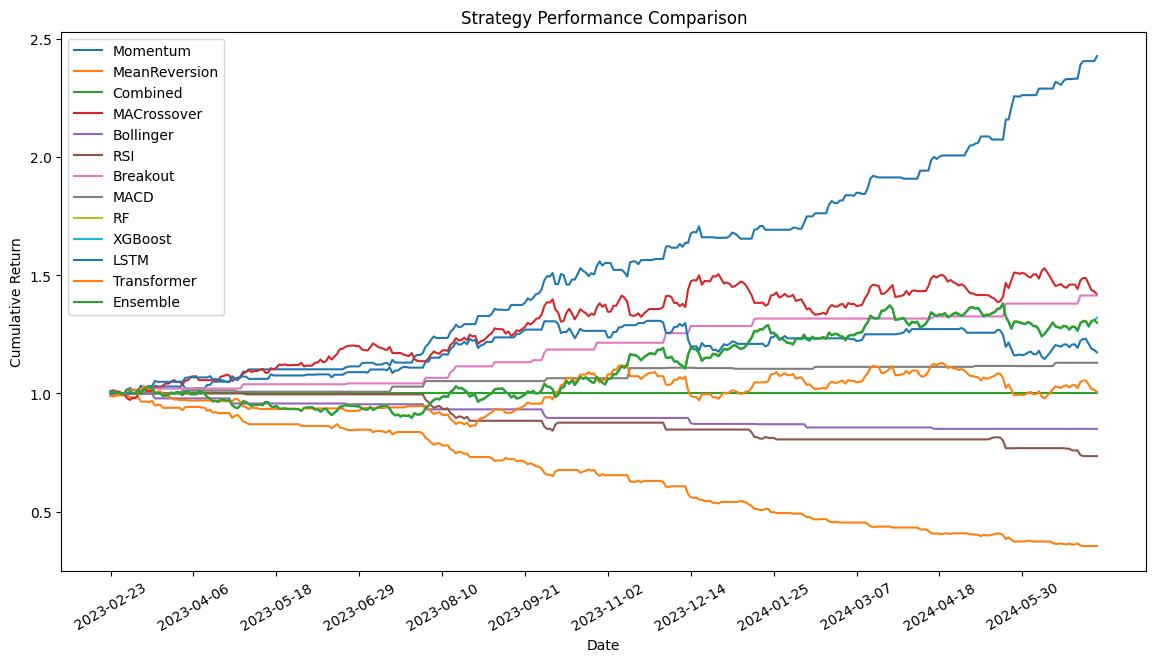

In [304]:
# Plot Cumulative Returns
plt.figure(figsize=(14, 7))

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    plt.plot(test_df['Date'], test_df[f'Cumulative_Return_{strategy}'], label=strategy)

# Manually set x-axis tick locations every 30 days
tick_locs = test_df['Date'][::30]
plt.gca().set_xticks(tick_locs) 
plt.xticks(rotation=30)  

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Performance Comparison')
plt.legend()
plt.show()


# Including Transaction Costs

In [301]:
commission_rate = 0.005  # 0.5%

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    test_df[f'Transaction_Cost_{strategy}'] = commission_rate * abs(test_df[f'Signal_{strategy}'].diff()) * test_df['Open']
    test_df[f'Transaction_Cost_{strategy}'].fillna(0, inplace=True)
    test_df[f'Net_Return_{strategy}'] = test_df[f'Return_{strategy}'] - test_df[f'Transaction_Cost_{strategy}'] / test_df['Open']
    
    # Recalculate cumulative net returns
    test_df[f'Cumulative_Net_Return_{strategy}'] = (1 + test_df[f'Net_Return_{strategy}'].fillna(0)).cumprod()


In [302]:
for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    # Recalculate performance metrics with net returns
    total_return = test_df[f'Cumulative_Net_Return_{strategy}'].iloc[-1] - 1
    num_days = len(test_df)
    annualized_return = (1 + total_return) ** (252 / num_days) - 1
    daily_return = test_df[f'Net_Return_{strategy}'].fillna(0)
    sharpe_ratio = daily_return.mean() / daily_return.std() * np.sqrt(252) if daily_return.std() != 0 else 0
    
    # Update performance DataFrame
    performance.loc[strategy, 'Total Return (Net)'] = total_return
    performance.loc[strategy, 'Annualized Return (Net)'] = annualized_return
    performance.loc[strategy, 'Sharpe Ratio (Net)'] = sharpe_ratio

print("Performance Metrics with Transaction Costs:")
print(performance[['Total Return (Net)', 'Annualized Return (Net)', 'Sharpe Ratio (Net)']])


Performance Metrics with Transaction Costs:
               Total Return (Net)  Annualized Return (Net)  Sharpe Ratio (Net)
Momentum                 0.396154                 0.264795            1.899917
MeanReversion           -0.764606                -0.638757           -6.698599
Combined                 0.000000                 0.000000            0.000000
MACrossover              0.297102                 0.200946            1.106505
Bollinger               -0.223711                -0.163268           -2.975929
RSI                     -0.348919                -0.260709           -3.396967
Breakout                 0.218842                 0.149474            2.193636
MACD                    -0.007560                -0.005327           -0.105668
RF                      -0.809499                -0.688748           -4.725522
XGBoost                 -0.800581                -0.678561           -4.592973
LSTM                    -0.193099                -0.140176           -1.021637
Transfor

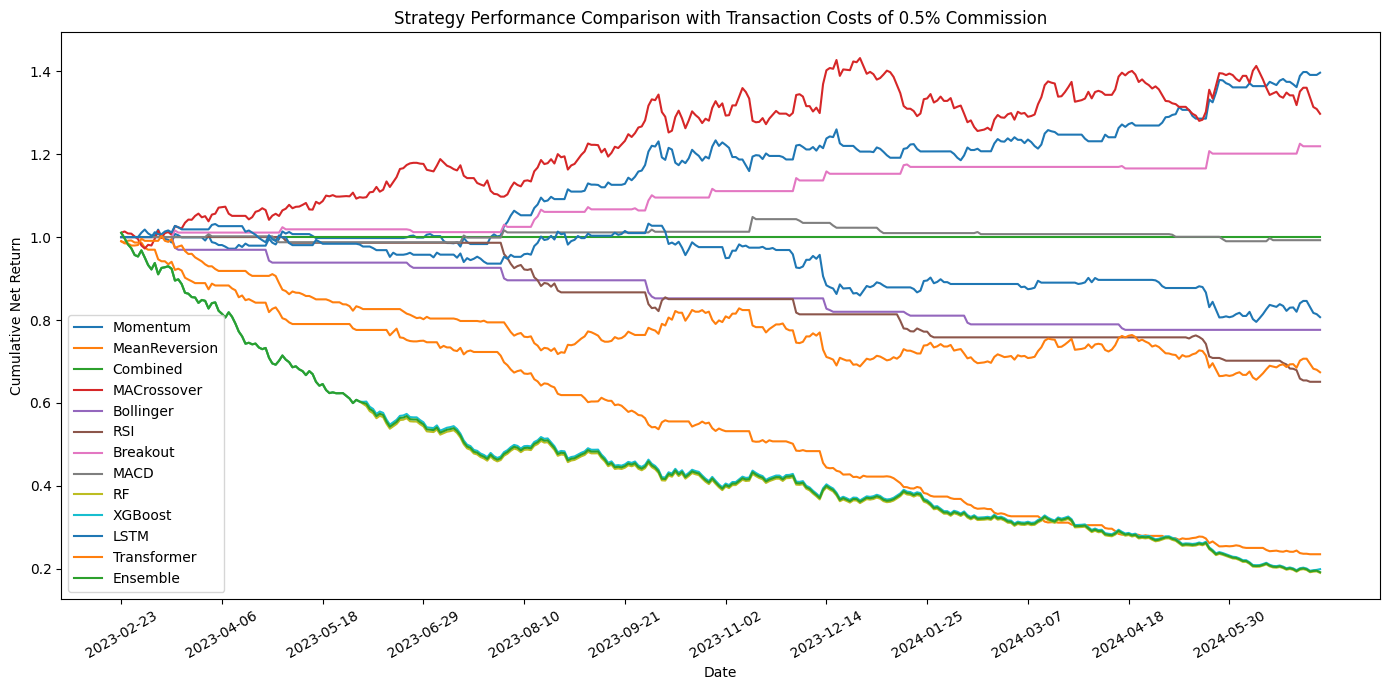

In [303]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    plt.plot(test_df['Date'], test_df[f'Cumulative_Net_Return_{strategy}'], label=strategy)

# Manually set x-axis tick locations every 30 days
tick_locs = test_df['Date'][::30]
plt.gca().set_xticks(tick_locs) 

# Optionally format tick labels
# plt.gca().set_xticklabels(tick_locs.dt.strftime('%Y-%m'), rotation=45)

plt.xlabel('Date')
plt.ylabel('Cumulative Net Return')
plt.title(f'Strategy Performance Comparison with Transaction Costs of {commission_rate * 100}% Commission')
plt.legend()

plt.xticks(rotation=30)  
plt.tight_layout()  
plt.show()
